<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span><ul class="toc-item"><li><span><a href="#Корреляционный-анализ" data-toc-modified-id="Корреляционный-анализ-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Корреляционный анализ</a></span></li></ul></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Подготовка данных</a></span></li><li><span><a href="#Обучение-и-выявление-лучшей-модели" data-toc-modified-id="Обучение-и-выявление-лучшей-модели-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Обучение и выявление лучшей модели</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Итоговые-выводы" data-toc-modified-id="Итоговые-выводы-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Итоговые выводы</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

Приступим к подготовке данных. Для начала, импортируем в одну ячейку все библиотеки, которыми будем пользоваться:

In [1]:
!pip install -q matplotlib==3.5.0 -q scikit-learn==1.1.3 -q pandas==1.5.3 
!pip install -q phik

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
import warnings
warnings.filterwarnings('ignore')
from statsmodels.tsa.seasonal import seasonal_decompose

import phik

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score, TimeSeriesSplit

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.metrics import mean_squared_error

RANDOM_STATE = 42
TEST_SIZE = 0.1

Напишем функцию для удобной подгрузки данных:

In [3]:
def upload_function(data, sep, decimal):
    try:
        info = pd.read_csv(f'/datasets/{data}.csv', sep=sep, decimal=decimal)
    except: 
        info = pd.read_csv(f'https://code.s3.yandex.net/datasets/{data}.csv', sep=sep, decimal=decimal)
    return info

Подгрузим данные:

In [4]:
taxi = upload_function('taxi', ',', ',')
display(taxi.head(10))

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32
5,2018-03-01 00:50:00,21
6,2018-03-01 01:00:00,7
7,2018-03-01 01:10:00,5
8,2018-03-01 01:20:00,17
9,2018-03-01 01:30:00,12


In [5]:
taxi.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


Пропусков нет, что не может не радовать. Сделаем индексами датафрейма столбец с датой, приведя его к соответствующему типу:

In [6]:
taxi['datetime'] = taxi['datetime'].astype('datetime64')
taxi.index = taxi['datetime']
taxi = taxi.drop('datetime', axis=1)
display(taxi.head(10))

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
2018-03-01 00:50:00,21
2018-03-01 01:00:00,7
2018-03-01 01:10:00,5
2018-03-01 01:20:00,17


Ресемплируем данные средним по одному часу:

In [7]:
taxi = taxi.resample('1H').sum()

In [8]:
display(taxi)

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
...,...
2018-08-31 19:00:00,136
2018-08-31 20:00:00,154
2018-08-31 21:00:00,159


Сделано. Теперь приступим к анализу нашего временного ряда.

## Анализ

Для анализа добавим столбцы с часом суток и с днем недели:

In [9]:
taxi['hour'] = taxi.index.hour
taxi['day_of_week'] = taxi.index.dayofweek
taxi['month'] = taxi.index.month
taxi['rolling_mean'] = taxi['num_orders'].shift(24).rolling(window=24).mean()
taxi

,num_orders,hour,day_of_week,month,rolling_mean
datetime,,,,,
2018-03-01 00:00:00,124,0,3,3,NaN
2018-03-01 01:00:00,85,1,3,3,NaN
2018-03-01 02:00:00,71,2,3,3,NaN
2018-03-01 03:00:00,66,3,3,3,NaN
2018-03-01 04:00:00,43,4,3,3,NaN
...,...,...,...,...,...
2018-08-31 19:00:00,136,19,4,8,172.875000
2018-08-31 20:00:00,154,20,4,8,170.833333
2018-08-31 21:00:00,159,21,4,8,172.000000


Суточные паттерны:

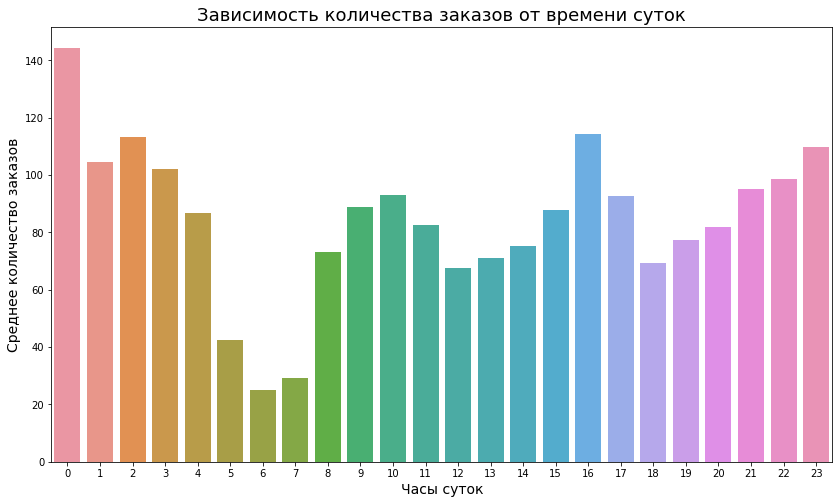

In [10]:
plt.figure(figsize=(14,8))
sns.barplot(data=taxi.groupby('hour')['num_orders'].mean().reset_index(), x='hour', y='num_orders')
plt.title('Зависимость количества заказов от времени суток', fontsize=18)
plt.xlabel('Часы суток', fontsize=14)
plt.ylabel('Среднее количество заказов', fontsize=14);

Дни недели:

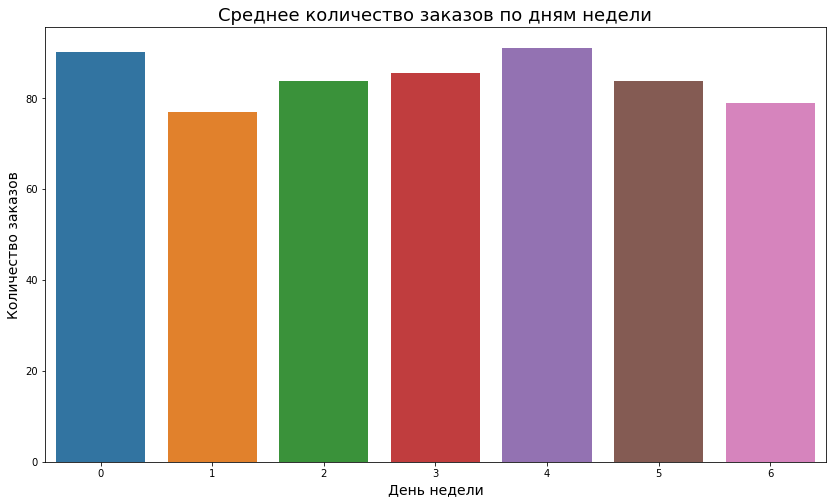

In [11]:
plt.figure(figsize=(14,8))
sns.barplot(data=taxi.groupby('day_of_week')['num_orders'].mean().reset_index(), x='day_of_week', y='num_orders')
plt.title('Среднее количество заказов по дням недели', fontsize=18)
plt.xlabel('День недели', fontsize=14)
plt.ylabel('Количество заказов', fontsize=14);

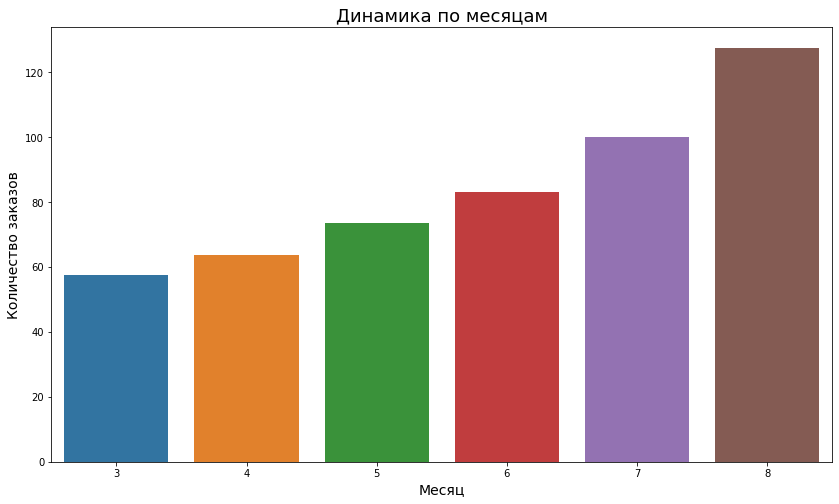

In [12]:
plt.figure(figsize=(14,8))
sns.barplot(data=taxi.groupby('month')['num_orders'].mean().reset_index(), x='month', y='num_orders')
plt.title('Динамика по месяцам', fontsize=18)
plt.xlabel('Месяц', fontsize=14)
plt.ylabel('Количество заказов', fontsize=14);

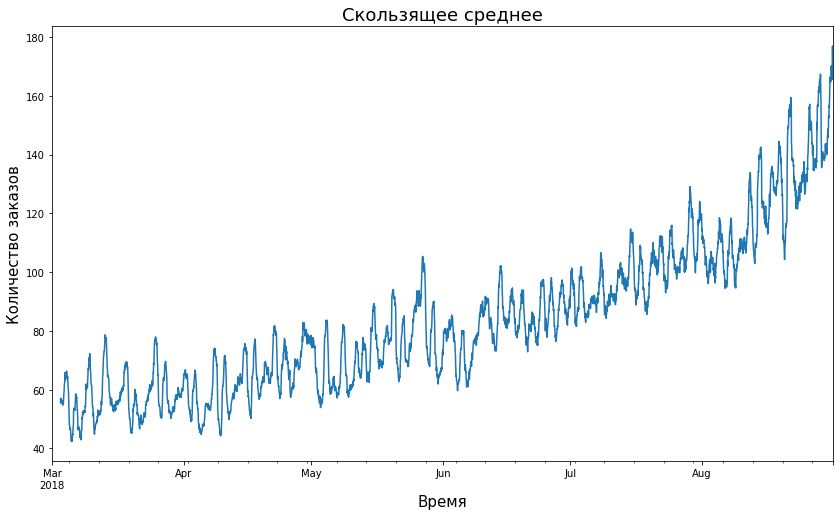

In [13]:
plt.figure(figsize=(14,8))
taxi['rolling_mean'].plot()
plt.title('Скользящее среднее', fontsize=18)
plt.xlabel('Время', fontsize=15)
plt.ylabel('Количество заказов', fontsize=15);

Декомпозируем данные, чтобы посмотреть тренды и сезонность:

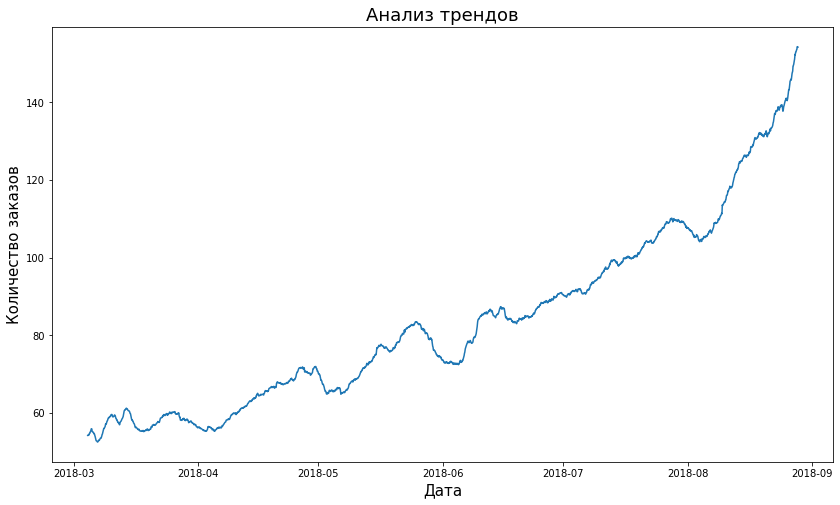

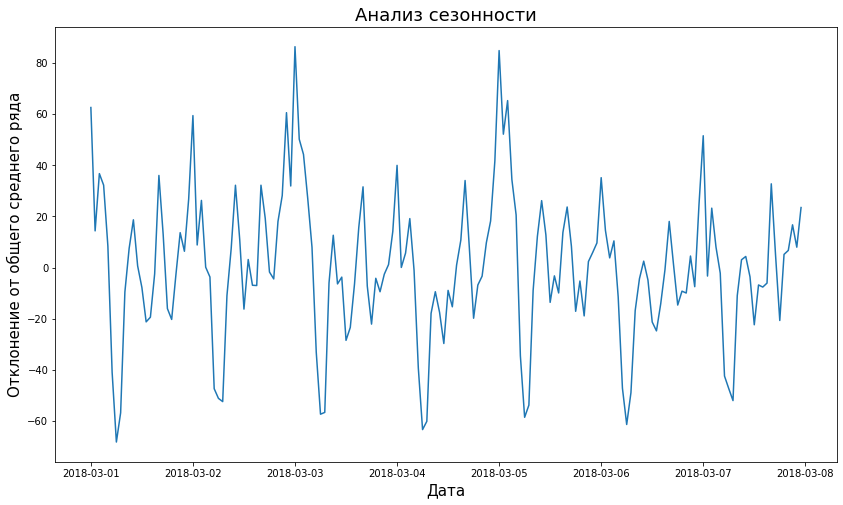

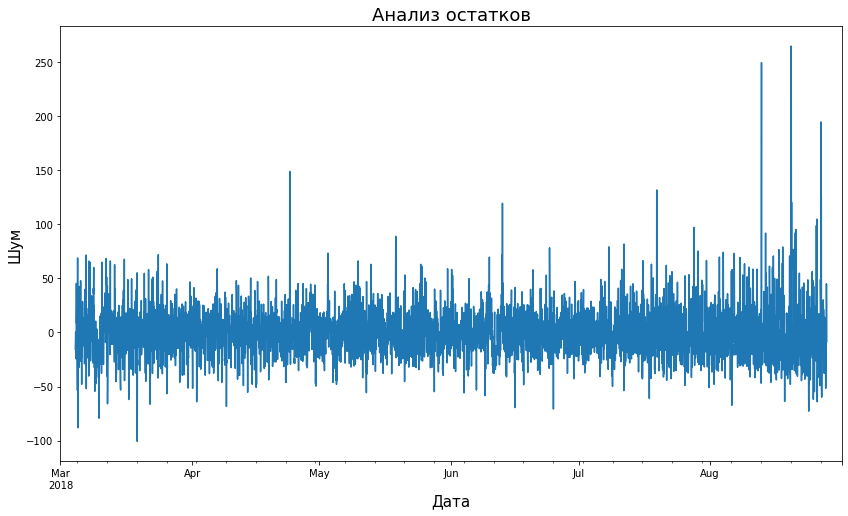

In [14]:
decomposed = seasonal_decompose(taxi['num_orders'], period=24*7)

plt.figure(figsize=(14,8))
plt.title('Анализ трендов', fontsize=18)
sns.lineplot(data=decomposed.trend)
plt.xlabel('Дата', fontsize=15)
plt.ylabel('Количество заказов', fontsize=15)
plt.show()

plt.figure(figsize=(14,8))
plt.title('Анализ сезонности', fontsize=18)
sns.lineplot(data=decomposed.seasonal['2018-03-01':'2018-03-07'])
plt.xlabel('Дата', fontsize=15)
plt.ylabel('Отклонение от общего среднего ряда', fontsize=15)
plt.show()

plt.figure(figsize=(14,8))
plt.title('Анализ остатков', fontsize=18)
decomposed.resid.plot()
plt.xlabel('Дата', fontsize=15)
plt.ylabel('Шум', fontsize=15)
plt.show()

**Промежуточные выводы**

По времени суток:
- Основной пик заказов приходится на ночное время: примерно с 9 вечера до 3 ночи, с пиком в полночь (*24* заказа)
- Небольшой пик утром: с 8 до 12
- Пик средней величины днем: с 14 до 18

Дни недели:
- Не так явно отличаются друг от друга, но больше всего заказов в понедельник, меньше всего во вторник.

Месяцы:
- Наглядно видно увеличение среднего числа заказов во всех данных, начиная с марта и достигая наибольшего значения под конец августа. Можно было бы предположить, что это связано с холодным временем года, но тогда и в марте было бы много заказов. Скорее всего, это связано с тем, что, под конец лета, много людей возвращается с отпусков.

Анализ трендов аналогичен анализу месяцев, сезонность выглядит периодической, какой и должна быть.

### Корреляционный анализ

Взглянем на корреляцию между признаками:

<AxesSubplot:>

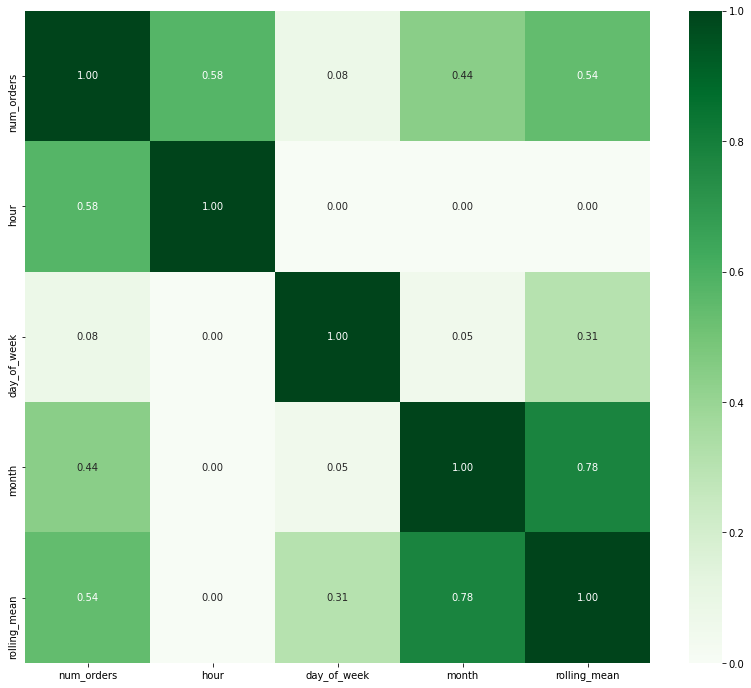

In [15]:
plt.figure(figsize=(14,12))
sns.heatmap(taxi.phik_matrix(interval_cols=['num_orders', 'rolling_mean']),
           annot=True,
           fmt='.2f',
           cmap='Greens')

Слишком сильной мультиколлинеарности нигде нет, посмотрим частичную и автокорреляцию ряда:

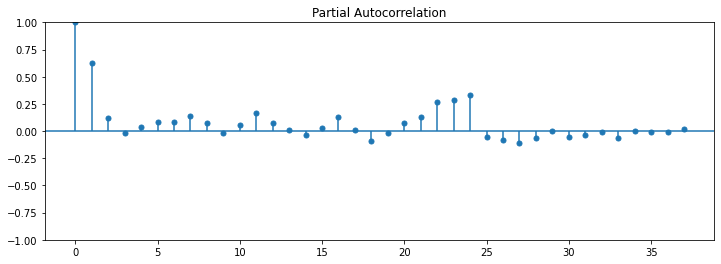

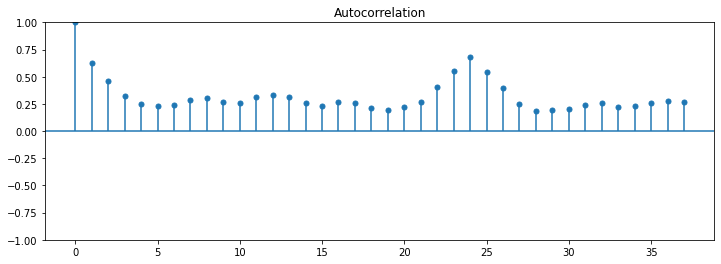

In [16]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_pacf(taxi['num_orders'], alpha=None).set_size_inches(12, 4)
plt.show()

plot_acf(taxi['num_orders'], alpha=None).set_size_inches(12, 4)
plt.show()

Так же отсутствует. Приступим к подготовке данных к машинному обучению.

## Обучение

### Подготовка данных

Подготовим данные к машинному обучению. Все признаки числовые, будем кодировать их с помощью *MinMaxScaler*, но, сначала, сконструируем признаки для обучения:

In [17]:
taxi = taxi.drop('month', axis=1)
taxi['lag_1'] = taxi['num_orders'].shift()
taxi['lag_2'] = taxi['num_orders'].shift(2)
taxi['lag_3'] = taxi['num_orders'].shift(3)
taxi['lag_4'] = taxi['num_orders'].shift(4)
taxi['lag_24'] = taxi['num_orders'].shift(24)
taxi['lag_48'] = taxi['num_orders'].shift(48)
taxi['lag_168'] = taxi['num_orders'].shift(168)
taxi

,num_orders,hour,day_of_week,rolling_mean,lag_1,lag_2,lag_3,lag_4,lag_24,lag_48,lag_168
datetime,,,,,,,,,,,
2018-03-01 00:00:00,124,0,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,1,3,NaN,124.0,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,2,3,NaN,85.0,124.0,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,3,3,NaN,71.0,85.0,124.0,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,4,3,NaN,66.0,71.0,85.0,124.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2018-08-31 19:00:00,136,19,4,172.875000,207.0,217.0,197.0,116.0,72.0,169.0,113.0
2018-08-31 20:00:00,154,20,4,170.833333,136.0,207.0,217.0,197.0,142.0,191.0,179.0
2018-08-31 21:00:00,159,21,4,172.000000,154.0,136.0,207.0,217.0,198.0,170.0,166.0


Разобьем датасет на выборки в соотношении 9:1 :

In [18]:
X = taxi.drop('num_orders', axis=1)
y = taxi['num_orders']

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=TEST_SIZE,
                                                    shuffle=False
                                                    )

In [19]:
data_preprocessor = ColumnTransformer([
    ('preprocessing', 
     Pipeline([
         ('imputer', SimpleImputer(strategy='most_frequent')),
         ('scaler', MinMaxScaler())
     ]), list(X_train.columns)
    )
], remainder='passthrough')

linear_model = Pipeline([
    ('prep', data_preprocessor),
    ('models', LinearRegression())
])

pipe_tree = Pipeline([
    ('prep', data_preprocessor),
    ('models', DecisionTreeRegressor(random_state=RANDOM_STATE))
])

pipe_boost = Pipeline([
    ('prep', data_preprocessor),
    ('models', GradientBoostingRegressor(random_state=RANDOM_STATE))
])

Будем перебирать три модели: линейную регрессию, дерево решений, градиентный бустинг. У каждой из них будем смотреть различные гиперпараметры (при помощи *RandomizedSearchCV* выберем лучшую модель с лучшими гиперпараметрами). Сделаем словарик для перебора гиперпараметров:

In [20]:
tree_params = [
    {
        'models__max_depth': range(1,51),
        'models__max_features': range(1,51),
        'models__min_samples_leaf': range(1,51),
        'models__min_samples_split': range(1,51)
    }
]

boosting_params = [    
    {
        'models__n_estimators': range(20,300),
        'models__learning_rate': np.linspace(0.01, 0.3, 20),
        'models__max_depth': range(1,11),
        'models__max_features': range(1,21),
        'models__min_samples_leaf': range(1,31),
        'models__min_samples_split': range(1,31)
    }
]

Итоговые модели:

In [21]:
tscv = TimeSeriesSplit(n_splits=5)

tree_model = RandomizedSearchCV(pipe_tree,
                               tree_params,
                               n_jobs=-1,
                               cv=tscv,
                               scoring='neg_mean_squared_error',
                               random_state=RANDOM_STATE)

gb_model = RandomizedSearchCV(pipe_boost,
                               boosting_params,
                               n_jobs=-1,
                               cv=tscv,
                               scoring='neg_mean_squared_error',
                               random_state=RANDOM_STATE)


### Обучение и выявление лучшей модели

Приступим к обучению моделей:

In [22]:
print('Метрика RMSE линейной регрессии при кросс-валидации на обучающей выборке:', 
      np.sqrt(-cross_val_score(linear_model, X_train, y_train, cv=tscv, scoring='neg_mean_squared_error').mean()))

Метрика RMSE линейной регрессии при кросс-валидации на обучающей выборке: 22.724345774930157


In [23]:
tree_model.fit(X_train, y_train)
print('Метрика RMSE дерева решений при кросс-валидации на обучающей выборке:', np.sqrt(-tree_model.best_score_))

Метрика RMSE дерева решений при кросс-валидации на обучающей выборке: 25.560377296992694


In [24]:
gb_model.fit(X_train, y_train)
print('Метрика RMSE бустинга при кросс-валидации на обучающей выборке:', np.sqrt(-gb_model.best_score_))

Метрика RMSE бустинга при кросс-валидации на обучающей выборке: 23.2123902647675


Лучше всего, как ни странно, справилась модель линейной регрессии. Ее и будем использовать для предсказаний на тестовой выборке.

In [25]:
linear_model.fit(X_train, y_train)

Pipeline(steps=[('prep',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('preprocessing',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  ['hour', 'day_of_week',
                                                   'rolling_mean', 'lag_1',
                                                   'lag_2', 'lag_3', 'lag_4',
                                                   'lag_24', 'lag_48',
                                                   'lag_168'])])),
                ('models', LinearRegression())])

Приступим к финальному тестированию.

## Тестирование

Инициализируем лучшую модель и проведем тестирование:

In [26]:
predictions = linear_model.predict(X_test)
print('Метрика RMSE лучшей модели на тестовой выборке:', np.sqrt(mean_squared_error(y_test, predictions)))

Метрика RMSE лучшей модели на тестовой выборке: 35.66004044271546


Готово, итоговая метрика выполняет условие поставленной задачи.

## Итоговые выводы

В ходе проекта решалась задача регрессии для временного ряда с количеством вызовов такси в различное время суток.

Данные были подгружены и изучены, после чего предобработаны. После подгрузки датасет был ресемплирован по одному часу, далее, индексами датафрейма были сделаны дата и время. Были добавлены столбцы с часом суток, днем недели, месяцем и скользящим средним.

После, был проведен исследовательский анализ, который показал, что: 

По времени суток:
- Основной пик заказов приходится на ночное время: примерно с 9 вечера до 3 ночи, с пиком в полночь (*24* заказа)
- Небольшой пик утром: с 8 до 12
- Пик средней величины днем: с 14 до 18

Дни недели:
- Не так явно отличаются друг от друга, но больше всего заказов в понедельник, меньше всего во вторник.

Месяцы:
- Наглядно видно увеличение среднего числа заказов во всех данных, начиная с марта и достигая наибольшего значения под конец августа. Можно было бы предположить, что это связано с холодным временем года, но тогда и в марте было бы много заказов. Скорее всего, это связано с тем, что, под конец лета, много людей возвращается с отпусков.

Анализ трендов аналогичен анализу месяцев, сезонность выглядит периодической, какой и должна быть. 

Корреляционный анализ не выявил мультиколлинеарности, а также частичной и автокорреляции.

Затем, данные были подготовлены к машинному обучению. Были добавлены признаки:
- Отстающих значений (на 1, 2, 3, 4, 48 (сутки) и 168 (неделя) часов

Датасет был поделен на тренировочную и тестовую выборки соотношением 9:1. Для обработки всех признаков (все они оказались количественными) был использован *MinMaxScaler*. Все это было сделано при помощи пайплайнов.

Были выбраны и обучены три модели - линейная регрессия, дерево решений и градиентный бустинг. Лучшие результаты показала модель линейной регрессии:
её метрика *RMSE*, полученная при помощи кросс-валидации на тренировочной выборке: **22.72**.

При помощи этой модели были сделаны предсказания на тестовой выборке. Метрика *RMSE* на тестовой выборке: **35.66**, что удовлетворяет условиям поставленной задачи.